## Random tests for coef

In [8]:
import argparse
import yaml
import numpy as np
import pickle as pkl
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime
import json
import hashlib
import os
import matplotlib.pyplot as plt

from algorithms import BMP
from data_generation import GaussianDataGenerator

In [9]:
p = 600
n = 300
m = 20
noise_level = 0.2

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, random_seed=1)
_ = Data_Geneartor.shuffle()

In [10]:
(
    test_true_signal,
    test_dictionary,
    true_indices,
    true_coefficients,
    test_perturbed_signal,
) = Data_Geneartor.get_current_shuffle()
print(test_perturbed_signal[:5])
print(true_coefficients[:5])

[[-0.19962958]
 [-0.37186517]
 [-0.20171144]
 [ 0.3839525 ]
 [ 0.28456818]]
[[ 0.82356385]
 [ 0.39110083]
 [ 0.27774159]
 [ 0.39934474]
 [-1.42959629]]


In [11]:
train_seed = 33
(
    train_true_signal,
    train_dictionary,
    true_indices,
    true_coefficients,
    train_perturbed_signal,
) = Data_Geneartor.keep_coef_reshuffle(seed = train_seed)

In [12]:
model_params = {
    'N_bag': 59,
    'K': 1,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

bmp_model = BMP(**model_params)

In [13]:
bmp_model.fit(train_dictionary, train_perturbed_signal)
y_pred = bmp_model.predict(test_dictionary)
bmp_model.score(test_dictionary, test_perturbed_signal)

0.08466016095722445

In [14]:
bmp_model.pred_corr(test_dictionary).shape

(1711,)

---------------------------

## Bias and Variance of single bmp

In [15]:
signal_bag_percent = 0.3
atom_bag_percent = 0.3

In [16]:
test_num = 1000
N_bag = 1

model_params_single = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': signal_bag_percent,
    'atom_bag_percent': atom_bag_percent,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_single['random_seed'] = data_seed + i
    bmp_model_single = BMP(**model_params_single)
    bmp_model_single.fit(train_dictionary, train_perturbed_signal)
    coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
    fit_coef_lst.append(coef_tmp)
    
fit_coef_single_mat = np.concatenate(fit_coef_lst, axis = 1)

true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients
true_coef_vec.shape

(600, 1)

In [17]:
fit_coef_single_mat.shape

(600, 1000)

In [18]:
fit_coef_single_mean = np.mean(fit_coef_single_mat, axis=1)
fit_coef_single_mean.shape

(600,)

In [19]:
fit_coef_single_bias = true_coef_vec.ravel() - fit_coef_single_mean.ravel()
fit_coef_single_bias.shape

(600,)

In [20]:
fit_coef_single_mean.shape

(600,)

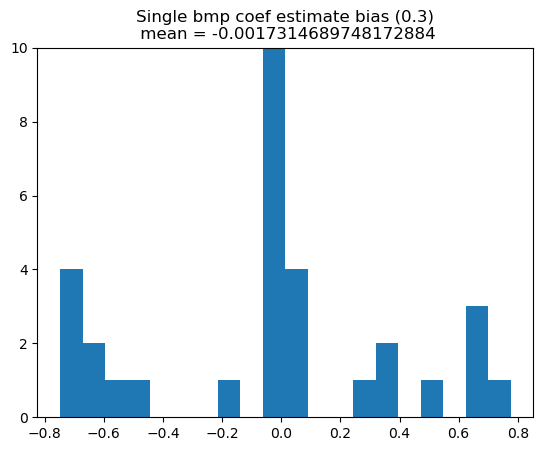

In [21]:
plt.hist(fit_coef_single_bias, bins=20)
fit_coef_single_bias_mean = np.mean(fit_coef_single_bias)
plt.title(f"Single bmp coef estimate bias (0.3)\n mean = {fit_coef_single_bias_mean}")
plt.ylim((0,10))
plt.show()

Variance of single mp

In [22]:
fit_coef_single_mat.shape

(600, 1000)

In [23]:
fit_coef_single_var = np.var(fit_coef_single_mat, axis=1)
fit_coef_single_var.shape

(600,)

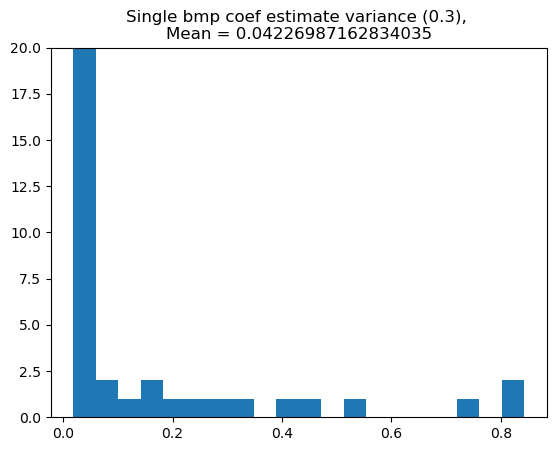

In [24]:
plt.hist(fit_coef_single_var, bins=20)
fit_coef_single_var_mean = np.mean(fit_coef_single_var)
plt.title("Single bmp coef estimate variance (0.3), \nMean = " + str(fit_coef_single_var_mean))
plt.ylim((0, 20))
plt.show()

----------------------

## MSE of ensembled model

In [26]:
test_num = 100
N_bag = 200

model_params_ensemble = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_ensemble_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_ensemble['random_seed'] = data_seed + i
    bmp_model_ensemble = BMP(**model_params_ensemble)
    bmp_model_ensemble.fit(train_dictionary, train_perturbed_signal)
    fit_coef_tmp = bmp_model_ensemble.coefficients.reshape(-1, 1)
    fit_coef_ensemble_lst.append(fit_coef_tmp)
    
fit_coef_ensemble_mat = np.concatenate(fit_coef_ensemble_lst, axis = 1)

true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients

In [27]:
fit_coef_ensemble_mat.shape

(600, 100)

In [28]:
ensemble_coef_bias_multitrial = fit_coef_ensemble_mat - true_coef_vec
ensemble_coef_sq_bias_multitrial = ensemble_coef_bias_multitrial ** 2
ensemble_coef_sq_bias_multitrial.shape

(600, 100)

In [29]:
ensemble_coef_sq_bias_multitrial_exp = np.mean(ensemble_coef_sq_bias_multitrial, axis = 1)
ensemble_coef_sq_bias_multitrial_exp.shape

(600,)

0.13115767042423168


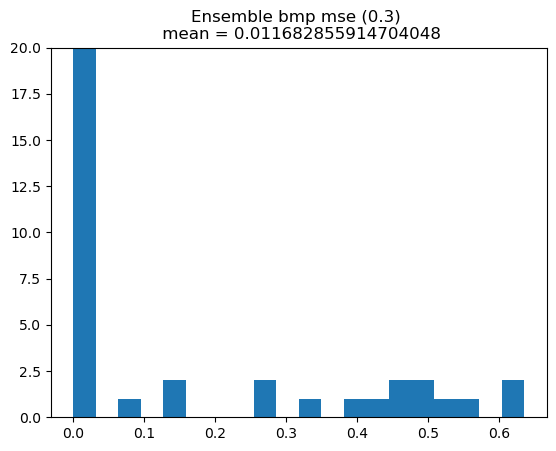

In [30]:
plt.hist(ensemble_coef_sq_bias_multitrial_exp, bins = 20)
ensemble_coef_sq_bias_multitrial_exp_19 = ensemble_coef_sq_bias_multitrial_exp[19]
print(ensemble_coef_sq_bias_multitrial_exp_19)
ensemble_coef_sq_bias_multitrial_exp_mean = np.mean(ensemble_coef_sq_bias_multitrial_exp)
plt.title('Ensemble bmp mse (0.3) \n mean = ' + str(ensemble_coef_sq_bias_multitrial_exp_mean))
plt.ylim((0, 20))
plt.show()

--------------

## Correlation

In [31]:
test_num = 400
N_bag = 200

model_params_single = {
    'N_bag': 1,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_bag_multitiral_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    fit_coef_bag = []
    for j in range(N_bag):
        model_params_single['random_seed'] = data_seed + j
        bmp_model_single = BMP(**model_params_single)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        fit_coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
        fit_coef_bag.append(fit_coef_tmp)
    fit_coef_bag_multitiral_lst.append(fit_coef_bag)

In [32]:
len(fit_coef_bag_multitiral_lst[0][0])

600

In [33]:
stack_lst = []
for i in range(len(fit_coef_bag_multitiral_lst)):
    tmp = np.concatenate(fit_coef_bag_multitiral_lst[i], axis=1)
    stack_lst.append(tmp)

d3 = np.stack(stack_lst)
d3.shape

(400, 600, 200)

In [34]:
slice_Nbag_testnum = d3[:, 1, :]
slice_Nbag_testnum.shape

(400, 200)

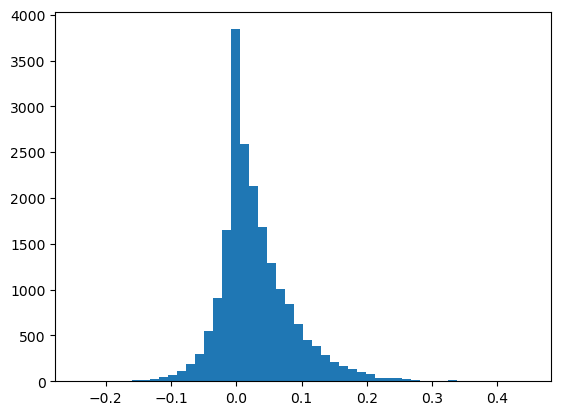

In [35]:
corr = np.corrcoef(slice_Nbag_testnum, rowvar=False)
corr.shape
upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
plt.hist(upper_corr, bins=50)
plt.show()

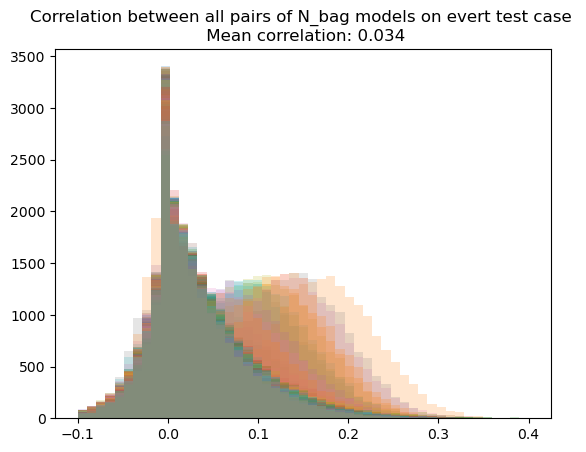

In [36]:
bins = np.linspace(-0.1, 0.4, 50)
all_corr = []

for i in range(d3.shape[1]):
    slice_tmp = d3[:, i, :]
    corr = np.corrcoef(slice_tmp, rowvar=False)
    upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
    all_corr.extend(upper_corr)
    plt.hist(upper_corr, bins=bins, alpha=0.2, label='test case {}'.format(i))
mean_corr = np.mean(all_corr)
plt.title('Correlation between all pairs of N_bag models on evert test case \n Mean correlation: {:.3f}'.format(mean_corr))
plt.show()


## Combining bias variance and correlation

In [37]:
fit_coef_single_bias.shape

(600,)

In [38]:
fit_coef_single_var.shape

(600,)

In [39]:
ensemble_coef_sq_bias_multitrial_exp.shape

(600,)

In [40]:
coef_mean_corr = []

for i in range(d3.shape[1]):
    slice_tmp = d3[:, i, :]
    corr = np.corrcoef(slice_tmp, rowvar=False)
    upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
    tmp_mean_corr = np.mean(upper_corr)
    coef_mean_corr.append(tmp_mean_corr)

coef_mean_corr = np.array(coef_mean_corr)
coef_mean_corr.shape

(600,)

In [58]:
coef_mean_corr[19]

0.04759768523909967

In [56]:
true_indices

array([135, 521, 114, 259, 374, 321, 224,  19, 416, 357, 157, 431, 371,
        78,  47, 129, 326, 168, 291,  86])

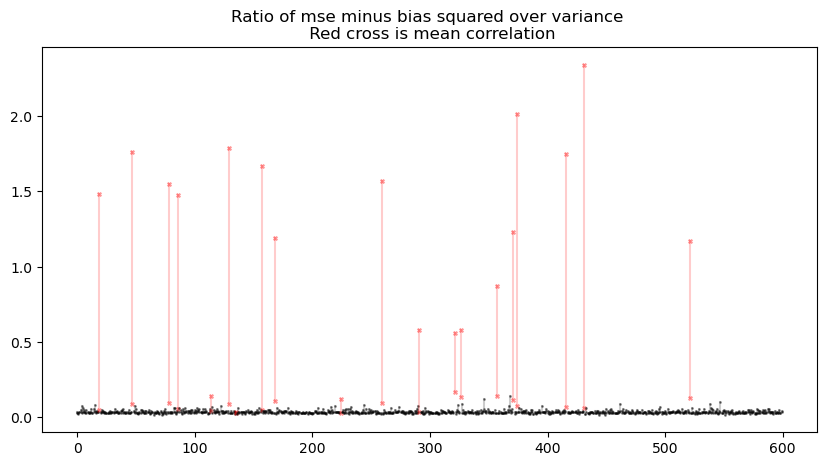

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(p):
    tmp_bias = fit_coef_single_bias[i]
    tmp_var = fit_coef_single_var[i]
    tmp_mse = ensemble_coef_sq_bias_multitrial_exp[i]
    tmp_corr = coef_mean_corr[i]
    mse_minus_biassq = tmp_mse 
    ratio_tmp = mse_minus_biassq / tmp_var
    if i in true_indices:
        plt.scatter(i, ratio_tmp, alpha=0.4, s = 7, color = 'red', marker='x')
        plt.scatter(i, tmp_corr, alpha=0.4, s = 7, color='red')
        plt.plot([i, i], [ratio_tmp, tmp_corr], color='red', alpha=0.2)
    else:
        plt.scatter(i, ratio_tmp, alpha=0.4, s = 1, color = 'black', marker='x')
        plt.scatter(i, tmp_corr, alpha=0.4, s = 1, color='black')
        plt.plot([i, i], [ratio_tmp, tmp_corr], color='black', alpha=0.2)
plt.title('Ratio of mse minus bias squared over variance \n Red cross is mean correlation')
plt.show()